<div style="position: absolute; top: 0; left: 0; font-family: 'Garamond'; font-size: 16px;">
    <a href="https://github.com/patriciaapenat" style="text-decoration: none; color: inherit;">Patricia Peña Torres</a>
</div>

<div align="center" style="font-family: 'Garamond'; font-size: 48px;">
    <strong>Proyecto final, BRFSS-clustering</strong>
</div>

<div align="center" style="font-family: 'Garamond'; font-size: 36px;">
    <strong>0.2. Análisis exploratorio</strong>
</div>

__________________

<div style="font-family: 'Garamond'; font-size: 14px;">

En este notebook se llava a cabo lo relativo al análisis exploratorio, por la naturaleza de los datos este EDA se ha centrado principalmente en variables demográficas
    
</div>

<div style="font-family: 'Garamond'; font-size: 16px;">
    <strong>Configuración del entorno de trabajo</strong>
</div>

In [1]:
import pandas as pd
import findspark
findspark.init()
import pyspark
import random
import os.path
import seaborn as sns
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import os
from pyspark.sql import DataFrame
import pickle
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from pyspark.ml.feature import Imputer
from functools import reduce
from pyspark.sql import DataFrame
import warnings
from pyspark.ml import Pipeline

# Ignorar advertencias deprecated
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# configurar gráficos
sns.set(style="whitegrid", context="notebook", palette="mako")

<div style="font-family: 'Garamond'; font-size: 14px;">
    <strong>Configuración de Spark</strong>
</div>

In [3]:
# Si hay un SparkContext existente, debemos cerrarlo antes de crear uno nuevo
if 'sc' in locals() and sc:
    sc.stop()  # Detener el SparkContext anterior si existe

# Configuración de Spark
conf = (
    SparkConf()
    .setAppName("Proyecto_PatriciaA_Peña")  # Nombre de la aplicación en Spark
    .setMaster("local[1]")  # Modo local con un hilo para ejecución
    .set("spark.driver.host", "127.0.0.1")  # Dirección del host del driver
    .set("spark.executor.heartbeatInterval", "3600s")  # Intervalo de latido del executor
    .set("spark.network.timeout", "7200s")  # Tiempo de espera de la red
    .set("spark.executor.memory", "14g")  # Memoria asignada para cada executor
    .set("spark.driver.memory", "14g")  # Memoria asignada para el driver
)

# Crear un nuevo SparkContext con la configuración especificada
sc = SparkContext(conf=conf)

# Configuración de SparkSession (interfaz de alto nivel para trabajar con datos estructurados en Spark)
spark = (
    SparkSession.builder
    .appName("Proyecto_PatriciaA_Peña")  # Nombre de la aplicación en Spark
    .config("spark.sql.repl.eagerEval.enabled", True)  # Habilitar la evaluación perezosa en Spark SQL REPL
    .config("spark.sql.repl.eagerEval.maxNumRows", 1000)  # Número máximo de filas a mostrar en la evaluación perezosa
    .getOrCreate()  # Obtener la sesión Spark existente o crear una nueva si no existe
) 

<div style="font-family: 'Garamond'; font-size: 14px;">
    <strong>Lectura del archivo</strong>
</div>

In [4]:
df = spark.read.format("csv").option("header", "true").load(r"C:\\Users\\patri\\OneDrive - UAB\\Documentos\\GitHub\\BRFSS-clustering\\datos\\BRFSS_imputated_2022.csv")

In [5]:
# Convertir todas las columnas a tipo numérico
for column_name in df.columns:
    df = df.withColumn(column_name, col(column_name).cast("double"))

In [6]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import functions as F
from pyspark.sql import Row


def evaluar_clustering_pyspark(tipo_clustering, modelo, datos, spark_session, metricas=None, nombre_modelo=None):
    # Inicializar las métricas como NaN
    metricas = {
        'Modelo': [nombre_modelo],
        'Coeficiente de Silueta': [np.nan],
        'Índice de Davies-Bouldin': [np.nan],
        'Índice Calinski-Harabasz': [np.nan],
        'Anomalías': [np.nan]
    }

    try:
        assembler = VectorAssembler(inputCols=datos.columns, outputCol="features")
        datos_con_features = assembler.transform(datos)

        # Obtener las etiquetas de cluster asignadas a cada registro
        resultados_clustering = modelo.transform(datos_con_features)

        # Calcular el coeficiente de silueta
        evaluator = ClusteringEvaluator()
        coeficiente_silueta = evaluator.evaluate(resultados_clustering)
        metricas['Coeficiente de Silueta'] = [coeficiente_silueta]

        # Otras métricas no soportadas directamente en PySpark
        metricas['Índice de Davies-Bouldin'] = [np.nan]
        metricas['Índice Calinski-Harabasz'] = [np.nan]

        # Detección de anomalías
        outliers = resultados_clustering.select("prediction").groupBy("prediction").count().filter(F.col("prediction") == -1).count()
        metricas['Anomalías'] = [outliers]

    except AttributeError as e:
        print(f"Error: {e}")

    # Crear un DataFrame con las métricas
    nuevas_metricas = pd.DataFrame(metricas)

    # Agregar las nuevas métricas al DataFrame existente o crear uno nuevo si no se proporciona ninguno
    if metricas is None:
        metricas = nuevas_metricas
    else:
        metricas = pd.concat([metricas, nuevas_metricas], ignore_index=True)

    return metricas

In [7]:
def graficar_clusters_spark(dataframe, labels, cluster_centers, titulo=None, etiqueta_x=None, etiqueta_y=None):
    # Reducción de dimensionalidad con PCA a 3 componentes
    pca = PCA(k=3, inputCol="features", outputCol="pca_features")
    data_pca_3d = pca.fit(dataframe).transform(dataframe).select("pca_features").rdd.map(lambda x: x.pca_features.toArray()).collect()
    data_pca_3d = np.array(data_pca_3d)

    # Graficar en 2D con puntos de datos y centroides
    plt.figure(figsize=(12, 6))
    ax1 = plt.subplot(121)
    ax1.scatter(dataframe[:, 0], dataframe[:, 1], c=labels, cmap='mako')
    ax1.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='*', c='red', s=100, label='Centroides')
    if titulo:
        ax1.set_title(titulo + ' - 2D')
    if etiqueta_x:
        ax1.set_xlabel(etiqueta_x)
    if etiqueta_y:
        ax1.set_ylabel(etiqueta_y)
    ax1.legend()

    # Graficar en 3D con puntos de datos y centroides
    ax2 = plt.subplot(122, projection='3d')
    ax2.scatter(data_pca_3d[:, 0], data_pca_3d[:, 1], data_pca_3d[:, 2], c=labels, cmap='mako', s=50)
    ax2.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2], marker='*', c='red', s=100, label='Centroides')
    if titulo:
        ax2.set_title(titulo + ' - 3D')
    if etiqueta_x:
        ax2.set_xlabel(etiqueta_x)
    if etiqueta_y:
        ax2.set_ylabel(etiqueta_y)
    ax2.set_zlabel('Eje Z')
    ax2.legend()

    # Mostrar los gráficos
    plt.tight_layout()
    plt.show()

In [8]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

# Definir el esquema del DataFrame
schema = StructType([
    StructField("Modelo", StringType(), True),
    StructField("Coeficiente de Silueta", DoubleType(), True),
    StructField("Índice de Davies-Bouldin", DoubleType(), True),
    StructField("Índice Calinski-Harabasz", DoubleType(), True),
    StructField("Anomalías", DoubleType(), True)
])

# Crear un DataFrame vacío con el esquema definido
df_metricas = spark.createDataFrame([], schema)

_______________________________

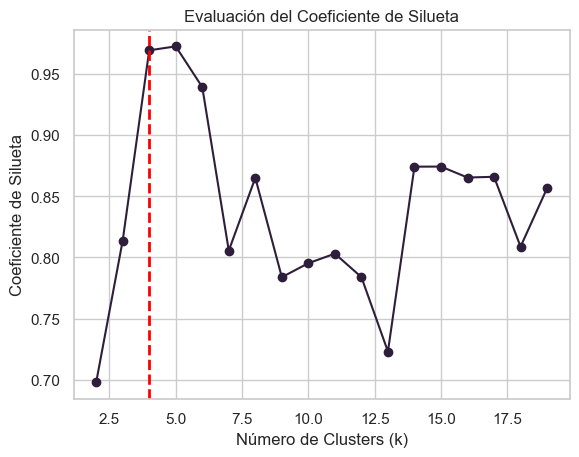

In [9]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import seaborn as sns


# Convertir las columnas de características a un solo vector columna
feature_cols = df.columns
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_vectorized = vector_assembler.transform(df)

# Crear una lista vacía para almacenar los valores del coeficiente de silueta
s_scores = []

# Probar diferentes valores de k (número de clusters)
for k in range(2, 20):
    kmeans = KMeans(featuresCol="features", k=k, initMode="k-means||", maxIter=300, seed=0)
    model = kmeans.fit(df_vectorized)

    # Obtener las predicciones
    predictions = model.transform(df_vectorized)

    # Evaluar el modelo utilizando el evaluador de clustering
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    
    # Añadir el coeficiente de silueta a la lista
    s_scores.append(silhouette)

# Trazar la curva del coeficiente de silueta en función del número de clusters
plt.plot(range(2, 20), s_scores, marker='o', linestyle='-', color=sns.color_palette('mako')[0])
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Coeficiente de Silueta')
plt.title('Evaluación del Coeficiente de Silueta')
plt.axvline(x=4, ymin=0, color='red', linewidth=2, ls='--')
plt.show()


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Crear una lista vacía para almacenar los valores del coeficiente de silueta
s_scores = []

# Probar diferentes valores de k (número de clusters)
for k in range(2, 20):
    # Configurar y ajustar el modelo KMeans
    kmeans = KMeans(k=k, seed=0)
    assembler = VectorAssembler(inputCols=df.columns, outputCol="features")
    df_con_features = assembler.transform(df)
    model = kmeans.fit(df_con_features)

    # Obtener las predicciones y evaluar el modelo
    predictions = model.transform(df_con_features)
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(predictions)

    # Agregar el coeficiente de silueta a la lista
    s_scores.append(silhouette_score)

# Trazar la curva del coeficiente de silueta en función del número de clusters
plt.plot(range(2, 20), s_scores, marker='o', linestyle='-', color=sns.color_palette('mako')[0])
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Coeficiente de Silueta')
plt.title('Evaluación del Coeficiente de Silueta')
plt.axvline(x=4, ymin=0, color='red', linewidth=2, ls='--')
plt.show()

In [ ]:
print("forma original:", df.shape)

In [ ]:
from pyspark.ml.feature import PCA

# Crear un objeto PCA con 4 componentes
pca = PCA(k=4, inputCol="features", outputCol="pca_features")
# Ajustar el modelo PCA al DataFrame
modelo_pca = pca.fit(df)
# Transformar el DataFrame utilizando el modelo PCA
df_transformado = modelo_pca.transform(df)
# Imprimir la forma transformada
print("Forma transformada:", df_transformado.count(), len(df_transformado.columns))

In [ ]:
print("forma original:", df.shape)

In [ ]:
from pyspark.ml.clustering import KMeans

# Crear una instancia del modelo KMeans con 4 clusters y 10 inicializaciones diferentes
kmeans = KMeans(k=4, initMode="k-means||", initSteps=10)
# Ajustar el modelo a los datos del DataFrame
modelo = kmeans.fit(df)
# Obtener las etiquetas de cluster asignadas a cada registro
resultados_clustering = modelo.transform(df)
# Obtener los centroides de los clusters
centroides_clusters = modelo.clusterCenters()

# Convertir los centroides de los clusters a un array de NumPy
centroides_array = np.array(centroides_clusters)

# Obtener las etiquetas de cluster asignadas a cada registro como un array de NumPy
etiquetas_array = np.array(resultados_clustering.select("prediction").collect())

# Obtener las características del DataFrame como un array de NumPy
caracteristicas_array = np.array(resultados_clustering.select("features").collect())

In [ ]:

# Llamar a la función para graficar los clusters
graficar_clusters_spark(caracteristicas_array, etiquetas_array, centroides_array, titulo="Gráfico de Clusters KMeans", etiqueta_x="Eje X", etiqueta_y="Eje Y")

In [ ]:
# Llama a la función evaluar_clustering_pyspark para obtener las métricas
metricas_resultantes = evaluar_clustering_pyspark('k', modelo, df, spark, nombre_modelo='KMeans')

# Agrega las nuevas métricas al DataFrame existente o crea uno nuevo si no existe
if df_metricas is None:
    df_metricas = metricas_resultantes
else:
    df_metricas = df_metricas.union(metricas_resultantes)

# Muestra el DataFrame con las métricas
df_metricas.show()